In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2022-05-22 08:18:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   126MB/s    in 0.5s    

2022-05-22 08:18:45 (126 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.748.jpg', 'cat.543.jpg', 'cat.659.jpg', 'cat.333.jpg', 'cat.371.jpg', 'cat.230.jpg', 'cat.501.jpg', 'cat.282.jpg', 'cat.646.jpg', 'cat.984.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


In [ ]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

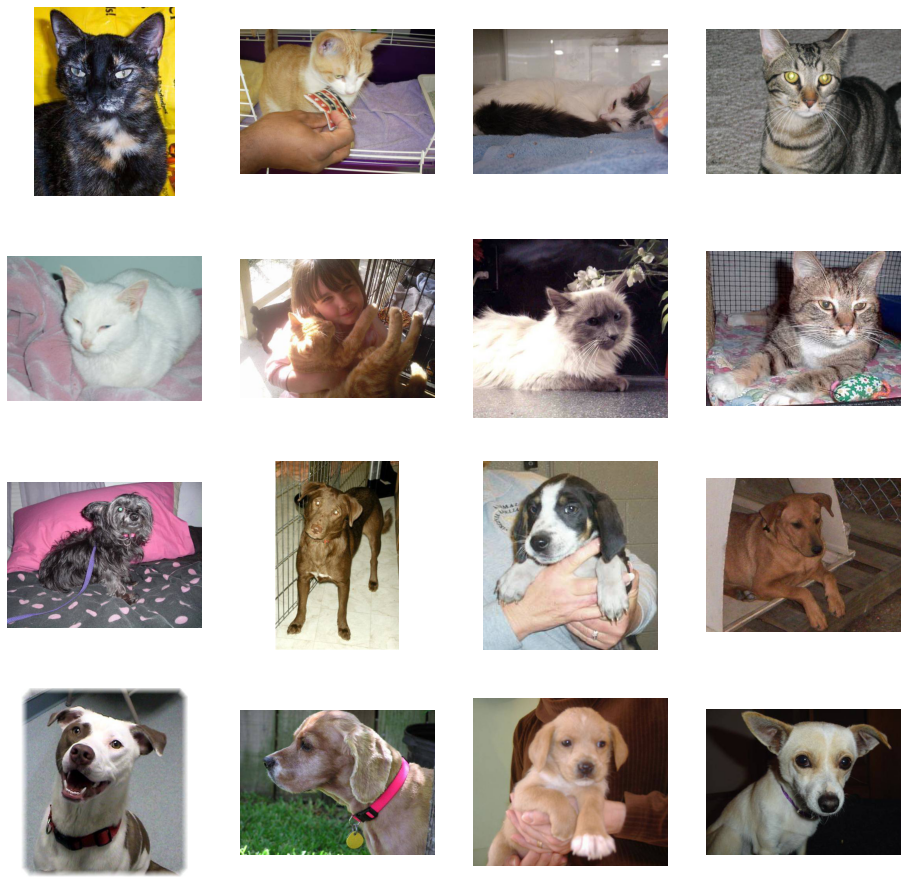

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


In [ ]:
import os
import zipfile
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import RMSprop

In [ ]:
def create_model():

  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  
  model.compile(optimizer=RMSprop(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 17, 17, 64)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest',
      validation_split=0.2
                                  )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=50,
    class_mode='binary',
    subset='training'
) 


validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(150, 150),
    batch_size=50,
    class_mode='binary',
    subset='validation')

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.90):
            self.model.stop_training = True
            
callback = mycallback()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples//50,#batch_size, 
    epochs = 10,
    verbose=1,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples//50,#batch_size,
    callbacks=[callback]
)

Epoch 1/10
32/32 [==============================] - 49s 2s/step - loss: 0.7212 - accuracy: 0.5100 - val_loss: 0.6876 - val_accuracy: 0.5550
Epoch 2/10
32/32 [==============================] - 50s 2s/step - loss: 0.6999 - accuracy: 0.5638 - val_loss: 0.6764 - val_accuracy: 0.5950
Epoch 3/10
32/32 [==============================] - 48s 2s/step - loss: 0.6770 - accuracy: 0.6037 - val_loss: 0.6495 - val_accuracy: 0.6525
Epoch 4/10
32/32 [==============================] - 48s 1s/step - loss: 0.6669 - accuracy: 0.6300 - val_loss: 0.7173 - val_accuracy: 0.5600
Epoch 5/10
32/32 [==============================] - 48s 2s/step - loss: 0.6430 - accuracy: 0.6450 - val_loss: 0.6308 - val_accuracy: 0.6900
Epoch 6/10
32/32 [==============================] - 48s 2s/step - loss: 0.6357 - accuracy: 0.6500 - val_loss: 0.6868 - val_accuracy: 0.6175
Epoch 7/10
32/32 [==============================] - 48s 2s/step - loss: 0.6395 - accuracy: 0.6381 - val_loss: 0.6201 - val_accuracy: 0.6475
Epoch 8/10
32/32 [==

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


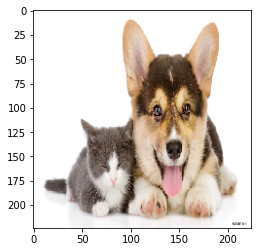

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
#_img = load_img("duck.jpg",target_size=(224,224))
_img = load_img("/content/drive/MyDrive/catsanddogdataset/image.jpg",target_size=(224,224))
plt.imshow(_img)
plt.show()

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

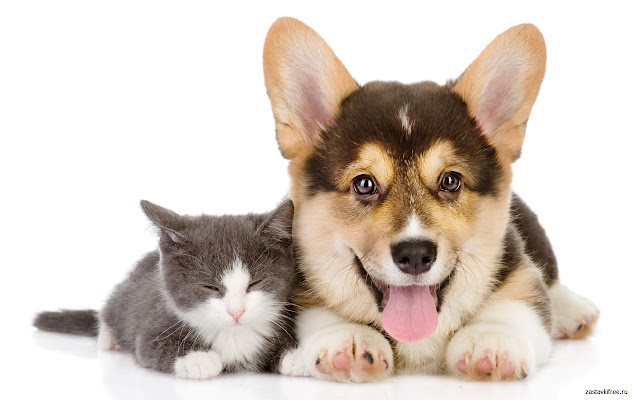

In [ ]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_19 (Conv2D)"

# The local path to our target image
img_path = "/content/drive/MyDrive/catsanddogdataset/image.jpg"

display(Image(img_path))